<a href="https://colab.research.google.com/github/dmklee/image2sphere/blob/main/visualize_trained_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook loads the I2S model with weights pretrained on PASCAL3D+.  The model predictions are visualized for several images from the test set.  At the bottom, you can evaluate the model on your own uploaded images.

# 0. Imports

In [ ]:
%%capture
! git clone https://github.com/dmklee/image2sphere.git
! pip install -r image2sphere/requirements.txt

In [38]:
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image
import glob
import sys
sys.path.append('image2sphere')
from src.predictor import I2S
from src.visualizations import plot_predictions

# 1. PASCAL3D+

## Instantiate Pretrained I2S
Here, we create an instance of I2S and load weights from a model trained for 40 epochs on PASCAL3D+.

In [ ]:
%%capture
# download the checkpoint
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dWlvGp1QY3esAqZgOnPikR6TpJmBUngd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dWlvGp1QY3esAqZgOnPikR6TpJmBUngd" -O pascal3d_checkpoint.pt && rm -rf /tmp/cookies.txt

# use untrained resnet101 to avoid downloading weights that will be overwritten
# this will take a minute to generate the Wigner-D matrices for the output grid
model = I2S(encoder='resnet101', eval_grid_rec_level=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(
    torch.load('pascal3d_checkpoint.pt', map_location=device)['model_state_dict'],
)
model.eval()

# Plot Predictions from PASCAL3D+ Test Set
We will load a subset of the PASCAL3D+ test set and visualize the predicted distributions of a pretrained I2S.

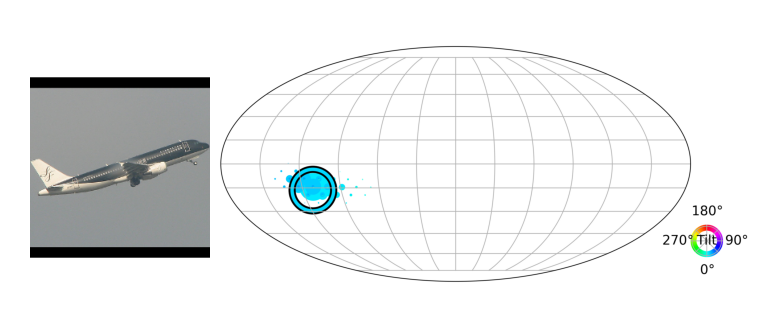

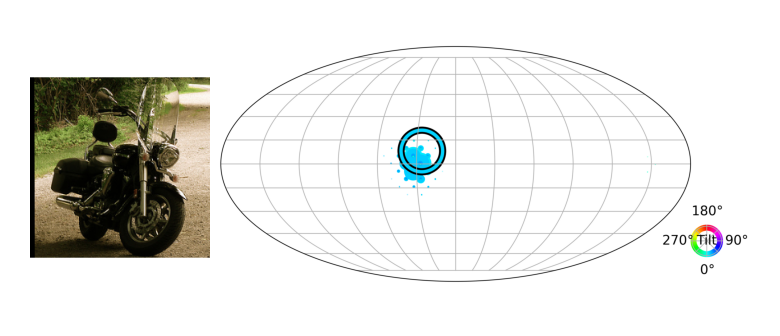

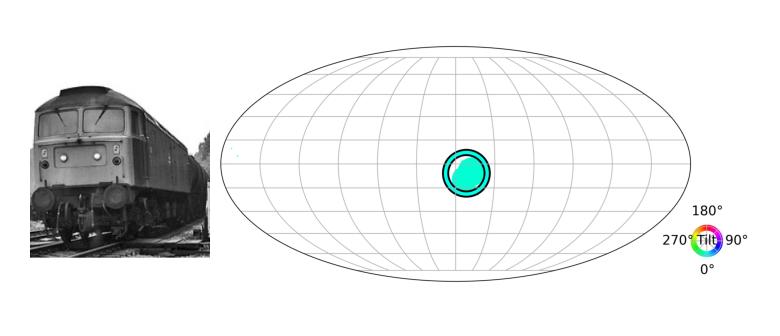

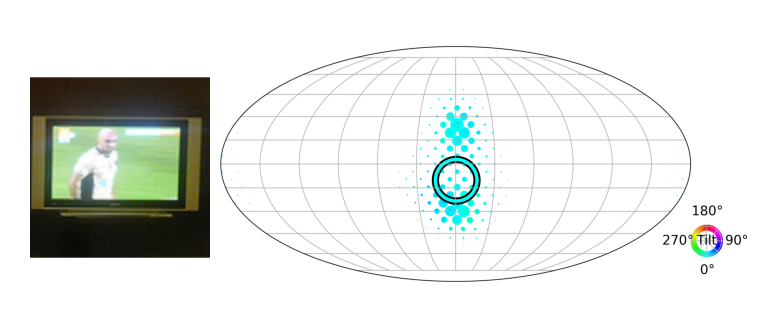

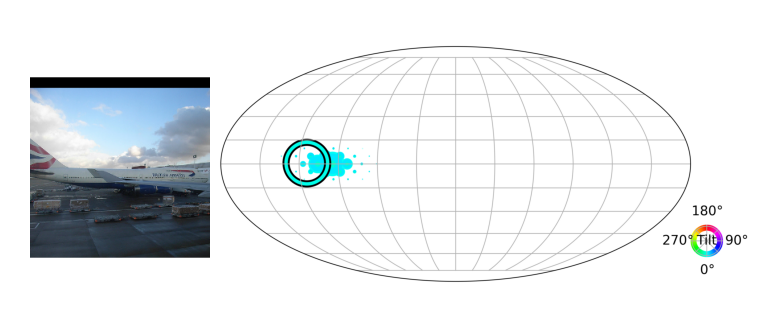

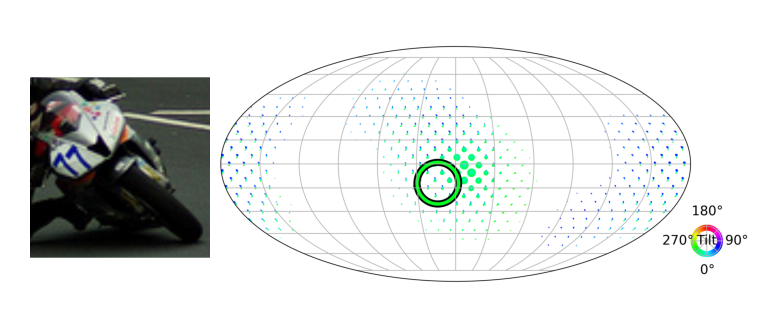

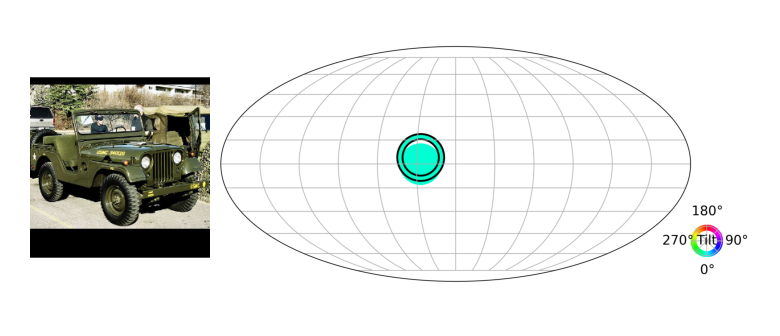

In [ ]:
mini_pascal = np.load('image2sphere/assets/mini_pascal.npz')
imgs = mini_pascal['imgs']
rots = mini_pascal['rots']

for img, rot in zip(imgs, rots):
  img = T.ToTensor()(img).unsqueeze(0)
  rot = torch.from_numpy(rot).unsqueeze(0)

  prob = model.compute_probabilities(img, None)
  
  plot_predictions(img, prob, model.eval_rotmats, gt_rots=rot, num=1)

# Plot Predictions on Novel Images
Here, you can upload a custom image and visualize the prediction.  You will get more reasonable predictions if you upload an image of an object that exists in PASCAL3D+: {plane, bicycle, boat, bottle, bus, car, chair, table, motorbike, sofa, train, tv}.

In [ ]:
## UPLOAD img: click "Choose Files" then select your image
## must be *.png or *.jpg (or change the glob command below)
from google.colab import files
uploaded = files.upload()

Saving plane.jpg to plane.jpg


/content/image2sphere/src/visualizations.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'90$\degree$', None,


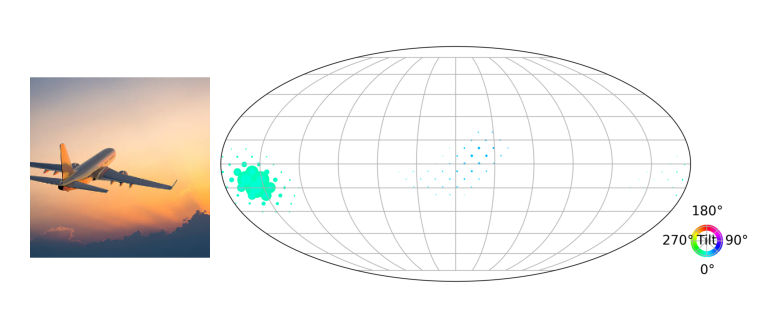

In [ ]:
img_files = glob.glob('*.jpg') + glob.glob('*.png')
for img_file in img_files:
  img = Image.open(img_file).convert('RGB')

  # resize and center crop
  img = T.ToTensor()(img)
  img = T.Resize(224)(img)
  img = T.CenterCrop(224)(img)
  img = img.unsqueeze(0)

  prob = model.compute_probabilities(img, None)

  plot_predictions(img, prob, model.eval_rotmats, num=1)

# 2. ModelNet10-SO(3)

## Instantiate I2S with pretrained weights

In [48]:
%%capture
# download the checkpoint
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wihL8AGfyrfDjp1mRjqkpvunMGfztSUa' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wihL8AGfyrfDjp1mRjqkpvunMGfztSUa" -O modelnet10so3_checkpoint.pt && rm -rf /tmp/cookies.txt

# use untrained resnet50 to avoid downloading weights that will be overwritten
# this will take a minute to generate the Wigner-D matrices for the output grid
model = I2S(encoder='resnet50', eval_grid_rec_level=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(
    torch.load('modelnet10so3_checkpoint.pt', map_location=device)['model_state_dict'],
)
model.eval()

## Show Predictions on Test Set

In [49]:
%%capture
# download modelnet10 testset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-oEjRO9XCs_CVpIX1B59sdiwan6AhZt3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-oEjRO9XCs_CVpIX1B59sdiwan6AhZt3" -O modelnet10_test.npz && rm -rf /tmp/cookies.txt

modelnet = np.load('modelnet10_test.npz')
modelnet_imgs = np.repeat(modelnet['imgs'], 3, axis=-1)
modelnet_rots = modelnet['rots']

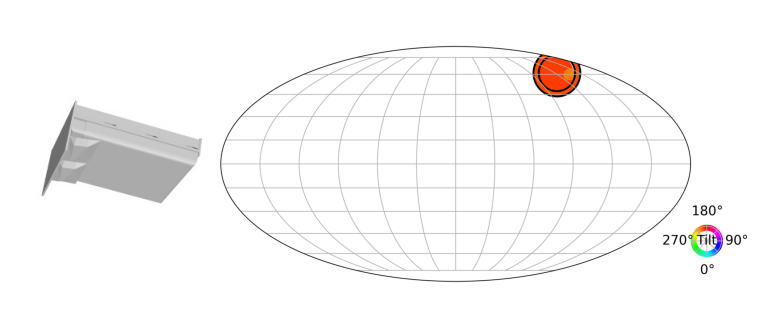

In [59]:
# randomly select data point
i = np.random.randint(len(modelnet_imgs))
img = T.ToTensor()(modelnet_imgs[i]).unsqueeze(0)
rot = torch.from_numpy(modelnet_rots[i]).unsqueeze(0)

prob = model.compute_probabilities(img, None)
plot_predictions(img, prob, model.eval_rotmats, gt_rots=rot, num=1)

## Robustness to Object Translation
Here we will see how robust I2S is to how well the object is centered in the image.  Keep in mind, the model was trained **only** on images where the object is perfectly centered.  To improve performance, we would want to retrain with random crop augmentations. You will notice some rotation error when the shift is greater than 20 pixels (i.e. 10% of image size).

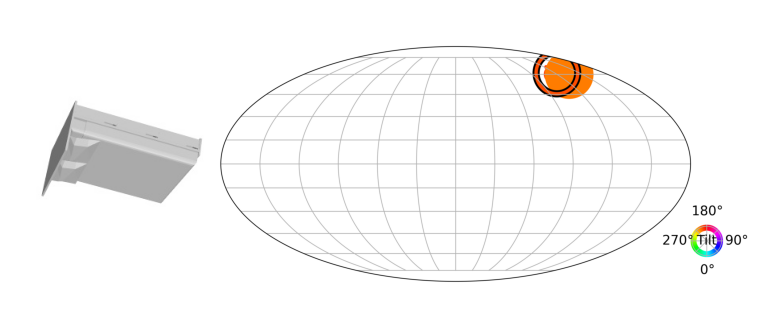

In [68]:
SHIFT = 20
shift_img = TF.crop(
    TF.pad(img, SHIFT//2, fill=1),
    top=0, left=0, height=224, width=224
)

rot = torch.from_numpy(modelnet_rots[i]).unsqueeze(0)

prob = model.compute_probabilities(shift_img, None)
plot_predictions(img, prob, model.eval_rotmats, gt_rots=rot, num=1)